In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import stats
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

347 total WT RuBisCOs
200 RuBisCOs with all core kinetic data measured


In [4]:
def make_PCA_data(df):
    """Simple function to put data into expected format for PCA.
    
    Assumes basis is [kcatC, KC, S, KC/KO] as in Savir 2010. 
    """
    vC_vals = df.vC.values
    Kc_vals = df.KC.values
    S_vals = df.S.values
    Kc_Ko_vals = Kc_vals / df.KO.values

    # Careful here: input data should have samples along rows, features along cols.
    data = np.vstack([vC_vals, Kc_vals, S_vals, Kc_Ko_vals]).T
    return data

In [5]:
# Perform PCA on kin_df - the subset of the data for which we have all values.
all_data = make_PCA_data(kin_df)
log_data = np.log(all_data)

# Standard scaler does a Z-transform
scaler = StandardScaler()
normed_log_data = scaler.fit_transform(log_data)

# Do the PCA
pca_normed = PCA()
fitted_normed = pca_normed.fit(normed_log_data)

In [6]:
print('PCA of all data, normalized in advance of PCA')
pct_variance_explained = 100*fitted_normed.explained_variance_ratio_

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted_normed.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted_normed.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)


PCA of all data, normalized in advance of PCA
$1^{st}$ PC explains 60.2% of variance
$2^{nd}$ PC explains 28.5% of variance
PC1 0.16 *log(vC) + 0.55 *log(KC) + -0.55 *log(S) + 0.61 *log(KC/KO)
PC2 -0.88 *log(vC) + -0.25 *log(KC) + -0.39 *log(S) + 0.1 *log(KC/KO)


In [7]:
# Perform PCA on form I rubiscos for which we have all data.
F1s = kin_df[kin_df.isoform == '1']
F1data = make_PCA_data(F1s)
log_F1_data = np.log(F1data)

# Standard scaler does a Z-transform
scaler = StandardScaler()
normed_logF1_data = scaler.fit_transform(log_F1_data)

# Do the PCA
pca = PCA()
fitted_F1_normed = pca.fit(normed_logF1_data)

In [8]:
print('PCA of FI data, normalized in advance of PCA')
pct_variance_explained = 100*fitted_F1_normed.explained_variance_ratio_
print(pct_variance_explained)

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted_F1_normed.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)
print(fitted_F1_normed.components_[0])
print()

complist = tuple(fitted_F1_normed.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)
print(fitted_F1_normed.components_[1])
print()

PCA of FI data, normalized in advance of PCA
[70.93578117 12.7886144  11.30176674  4.97383769]
$1^{st}$ PC explains 70.9% of variance
$2^{nd}$ PC explains 12.8% of variance
PC1 0.47 *log(vC) + 0.52 *log(KC) + -0.48 *log(S) + 0.53 *log(KC/KO)
[ 0.46786422  0.52371815 -0.4757601   0.52959862]

PC2 -0.66 *log(vC) + 0.49 *log(KC) + 0.37 *log(S) + 0.43 *log(KC/KO)
[-0.66273283  0.49030896  0.36735181  0.4306216 ]



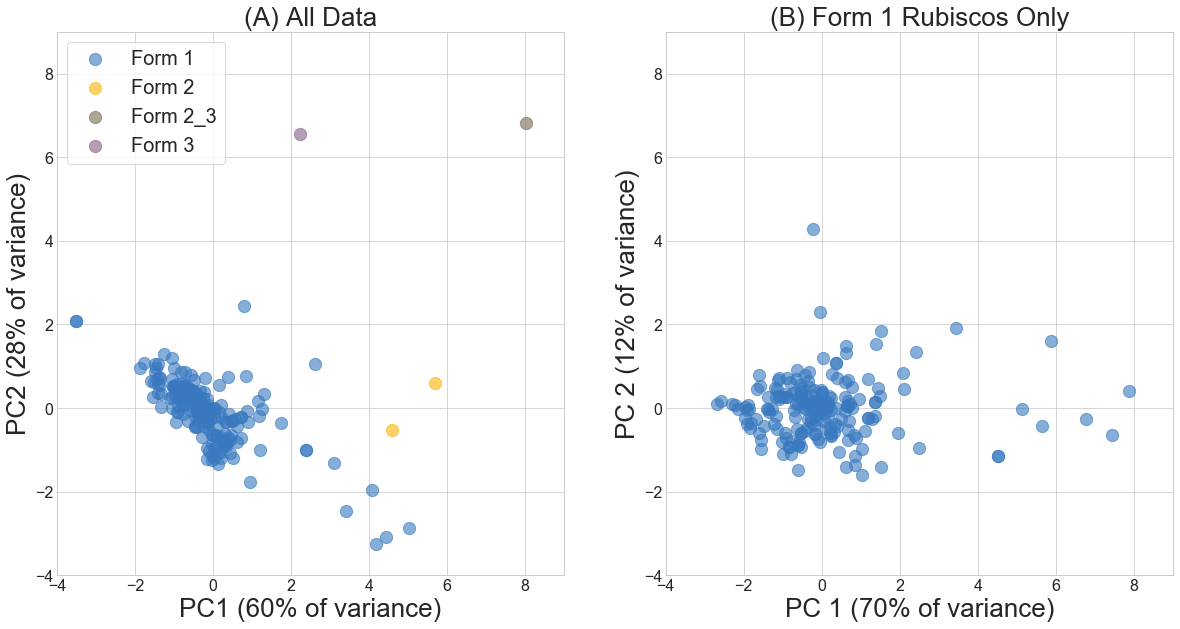

In [9]:
# Plot 2D projections for full dataset and F1 subset
fig = plt.figure(figsize=(20, 10))
seaborn.set_style('whitegrid')

# F1 subset in this subplot
plt.subplot(1, 2, 1)

pcts = 100*fitted_normed.explained_variance_ratio_
transformed_normed = fitted_normed.transform(normed_log_data)
forms = sorted(kin_df.isoform.unique())
colormapping = dict((forms[i], named_colors[i]) for i in range(len(forms)))

for form in forms:
    idxs = np.where(kin_df.isoform == form)
    color = colormapping[form]
    l = 'Form %s' % form
    plt.scatter(transformed_normed[idxs, 0], transformed_normed[idxs, 1], s=150, c=color, label=l, alpha=0.6)

plt.xlabel('PC1 (%d%% of variance)' % pcts[0], fontsize=26)
plt.ylabel('PC2 (%d%% of variance)' % pcts[1], fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-4, 9)
plt.ylim(-4, 9)
plt.title('(A) All Data', fontsize=26)
plt.legend(loc=2, fontsize=20, frameon=True)

# F1 subset in this subplot
plt.subplot(1, 2, 2)
seaborn.set_style('whitegrid')

pcts = 100*fitted_F1_normed.explained_variance_ratio_
transformed = fitted_F1_normed.transform(normed_logF1_data)

plt.scatter(transformed[:, 0], transformed[:, 1], s=150, c=named_colors[0], alpha=0.6)

plt.title('(B) Form 1 Rubiscos Only', fontsize=26)
plt.xlabel('PC 1 (%d%% of variance)' % pcts[0], fontsize=26)
plt.ylabel('PC 2 (%d%% of variance)' % pcts[1], fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-4, 9)
plt.ylim(-4, 9)

plt.savefig('figS6/figS6_PCA_2D.png', dpi=600)
plt.show()

In [10]:
# Perform PCA on Rubisco from Savir 2010 for which all data was available
mask = savir_df.S.notnull()
mask &= savir_df.vC.notnull()
mask &= savir_df.KC.notnull()
mask &= savir_df.KO.notnull()
# Savir excludes the FII data.
mask &= savir_df.isoform != '2'
savir_subset = savir_df[mask]

savir_data = make_PCA_data(savir_subset)
log_savir_data = np.log(savir_data)

# Standard scaler does a Z-transform
scaler = StandardScaler()
normed_savir_data = scaler.fit_transform(log_savir_data)

# Do the PCA
pca = PCA()
fitted_savir_normed = pca.fit(normed_savir_data)

In [11]:
print('PCA of Savir data, normalized in advance of PCA')
pct_variance_explained = 100*fitted_savir_normed.explained_variance_ratio_
print(pct_variance_explained)

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted_savir_normed.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)
print(fitted_F1_normed.components_[0])
print()

complist = tuple(fitted_savir_normed.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)
print(fitted_F1_normed.components_[1])
print()

PCA of Savir data, normalized in advance of PCA
[91.02110938  6.23818441  2.13998107  0.60072514]
$1^{st}$ PC explains 91.0% of variance
$2^{nd}$ PC explains 6.2% of variance
PC1 0.52 *log(vC) + 0.5 *log(KC) + -0.48 *log(S) + 0.5 *log(KC/KO)
[ 0.46786422  0.52371815 -0.4757601   0.52959862]

PC2 -0.0022 *log(vC) + 0.48 *log(KC) + 0.82 *log(S) + 0.3 *log(KC/KO)
[-0.66273283  0.49030896  0.36735181  0.4306216 ]

